In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
import pickle
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

# Physical constants
RSUN_AU = 0.00465047  # R_sun in AU
RJUP_TO_RSUN = 0.10049  # R_jup / R_sun

print("Libraries loaded successfully.")
print(f"Constants: R_sun = {RSUN_AU:.6f} AU, R_jup/R_sun = {RJUP_TO_RSUN:.5f}")

Libraries loaded successfully.
Constants: R_sun = 0.004650 AU, R_jup/R_sun = 0.10049


## 1. Load Raw Data (Stellar Parameters)

Load the raw MCS and TPC files to extract stellar parameters with uncertainties.

In [2]:
# Load raw data files
mcs_file = '../../data/raw/Ariel_MCS_Known_2025-07-18.csv'
tpc_file = '../../data/raw/Ariel_MCS_TPCs_2025-07-18.csv'

mcs_raw = pd.read_csv(mcs_file)
tpc_raw = pd.read_csv(tpc_file)

print(f"MCS Known Planets: {len(mcs_raw)}")
print(f"TPC Candidates: {len(tpc_raw)}")

# Check available stellar parameter columns
print("\nMCS columns with 'star' or 'stellar':")
stellar_cols = [col for col in mcs_raw.columns if 'star' in col.lower() or 'stellar' in col.lower()]
for col in stellar_cols:
    print(f"  {col}")

print("\nMCS columns with 'temp' or 'radius':")
param_cols = [col for col in mcs_raw.columns if 'temp' in col.lower() or 'radius' in col.lower()]
for col in param_cols:
    print(f"  {col}")

MCS Known Planets: 808
TPC Candidates: 2046

MCS columns with 'star' or 'stellar':
  Star Name
  Star Mass [Ms]
  Star Mass Error Lower [Ms]
  Star Mass Error Upper [Ms]
  Star Temperature [K]
  Star Temperature Error Lower [K]
  Star Temperature Error Upper [K]
  Star Radius [Rs]
  Star Radius Error Lower [Rs]
  Star Radius Error Upper [Rs]
  Star log(g)
  Star log(g) Error Lower
  Star log(g) Error Upper
  Star Metallicity
  Star Metallicity Error Lower
  Star Metallicity Error Upper
  Star Age [Gyr]
  Star Age Error Lower [Gyr]
  Star Age Error Upper [Gyr]
  Star Spectral Type
  Star Rotational Velocity [km/s]
  Star Rotational Velocity Error Lower [km/s]
  Star Rotational Velocity Error Upper [km/s]
  Star Rotation Period [days]
  Star Rotation Period Error Lower [days]
  Star Rotation Period Error Upper [days]
  Star Distance [pc]
  Star Distance Error Lower [pc]
  Star Distance Error Upper [pc]
  Star Parallax [mas]
  Star Parallax Error Lower [mas]
  Star Parallax Error Upper [m

## 2. Load MCMC Results from b_occ Analysis

Load the saved MCMC results which contain the posterior distributions of orbital parameters.

In [3]:
# Load MCMC results
mcs_mcmc_file = '../results/mcs_eclipse_impact_parameter_mcmc.csv'
tpc_mcmc_file = '../results/tpc_eclipse_impact_parameter_mcmc.csv'
combined_mcmc_file = '../results/eclipse_impact_parameter_mcmc_combined.csv'

if os.path.exists(combined_mcmc_file):
    mcmc_results = pd.read_csv(combined_mcmc_file)
    print(f"Loaded MCMC results: {len(mcmc_results)} systems")
    print(f"\nColumns in MCMC results:")
    for col in mcmc_results.columns:
        print(f"  {col}")
    
    # Dataset breakdown
    print(f"\nDataset breakdown:")
    for dataset in mcmc_results['Dataset'].unique():
        count = len(mcmc_results[mcmc_results['Dataset'] == dataset])
        print(f"  {dataset}: {count}")
    
    display(mcmc_results.head())
else:
    print(f"ERROR: MCMC results file not found: {combined_mcmc_file}")
    print("Please run eclipse_impact_parameter_mcmc.ipynb Cell 10 first.")

Loaded MCMC results: 2854 systems

Columns in MCMC results:
  Planet
  Dataset
  eclipse_observed
  b_occ_median
  b_occ_16
  b_occ_84
  b_occ_std
  b_occ_err_lower
  b_occ_err_upper
  k_rp_rs
  one_minus_k
  one_plus_k
  acceptance_fraction

Dataset breakdown:
  MCS: 808
  TPC: 2046


,Planet,Dataset,eclipse_observed,b_occ_median,b_occ_16,b_occ_84,b_occ_std,b_occ_err_lower,b_occ_err_upper,k_rp_rs,one_minus_k,one_plus_k,acceptance_fraction
0,K2-232b,MCS,False,0.108497,0.028319,0.199770,0.087795,0.080178,0.091273,0.088110,0.911890,1.088110,0.495427
1,Qatar-10b,MCS,False,0.329138,0.226816,0.439807,0.110100,0.102322,0.110669,0.126500,0.873500,1.126500,0.492677
2,WASP-60b,MCS,False,0.337115,0.075208,0.626965,0.290520,0.261907,0.289851,0.077523,0.922477,1.077523,0.492312
3,WASP-20b,MCS,False,0.699220,0.545897,0.807602,0.157890,0.153323,0.108382,0.107930,0.892070,1.107930,0.491604
4,HATS-52b,MCS,False,0.448388,0.314825,0.587241,0.141546,0.133563,0.138853,0.135200,0.864800,1.135200,0.494500


## 3. Define Physics Functions

Define functions for calculating planet temperature and eclipse depth.

In [4]:
def planet_temperature(T_star, R_star_rsun, a_au, epsilon=0.8, A=None):
    """
    Calculate planet equilibrium temperature using Tessenyi et al. (2012) formulation.
    
    T_p = T_star * (sqrt(1 - A) * R_star / (2 * a * epsilon))^(1/2)
    
    Parameters:
    -----------
    T_star : float
        Stellar effective temperature (K)
    R_star_rsun : float
        Stellar radius (R_sun)
    a_au : float
        Semi-major axis (AU)
    epsilon : float, optional
        Greenhouse effect parameter (default: 0.8)
        Following Tessenyi et al. (2012)
    A : float, optional
        Planetary albedo. If None, uses temperature-dependent values:
        - A = 0.3 for T_p < 700 K (cool planets)
        - A = 0.1 for T_p > 700 K (hot planets)
        Following Tessenyi et al. (2012), Seager & Mallén-Ornelas (2003)
    
    Returns:
    --------
    T_p : float
        Planet equilibrium temperature (K)
    
    References:
    -----------
    Tessenyi et al. (2012)
    Seager & Mallén-Ornelas (2003)
    """
    R_star_au = R_star_rsun * RSUN_AU
    
    # If albedo not specified, use iterative approach with temperature-dependent albedo
    if A is None:
        # Initial guess assuming hot planet (A = 0.1)
        A_initial = 0.1
        T_p_guess = T_star * (np.sqrt(1 - A_initial) * R_star_au / (2 * a_au * epsilon)) ** 0.5
        
        # Update albedo based on temperature
        if T_p_guess < 700:
            A = 0.3  # Cool planet
        else:
            A = 0.1  # Hot planet
        
        # Recalculate with correct albedo
        T_p = T_star * (np.sqrt(1 - A) * R_star_au / (2 * a_au * epsilon)) ** 0.5
    else:
        # Use specified albedo
        T_p = T_star * (np.sqrt(1 - A) * R_star_au / (2 * a_au * epsilon)) ** 0.5
    
    return T_p


def eclipse_depth(R_p_rjup, R_star_rsun, T_p, T_star):
    """
    Calculate bolometric eclipse depth.
    
    δ_eclipse = (R_p/R_star)² × (T_p/T_star)⁴
    
    Parameters:
    -----------
    R_p_rjup : float
        Planet radius (R_jup)
    R_star_rsun : float
        Stellar radius (R_sun)
    T_p : float
        Planet temperature (K)
    T_star : float
        Stellar temperature (K)
    
    Returns:
    --------
    delta : float
        Eclipse depth (dimensionless, not in ppm)
    """
    R_p_rsun = R_p_rjup * RJUP_TO_RSUN
    geometric = (R_p_rsun / R_star_rsun) ** 2
    thermal = (T_p / T_star) ** 4
    return geometric * thermal


# Test functions with example values
print("Testing physics functions:\n")

# HD 189733 b (hot Jupiter with known eclipse)
T_star_test = 5000  # K
R_star_test = 0.76  # R_sun
a_test = 0.031  # AU
R_p_test = 1.14  # R_jup

T_p_test = planet_temperature(T_star_test, R_star_test, a_test)
delta_test = eclipse_depth(R_p_test, R_star_test, T_p_test, T_star_test)

print(f"Test system (HD 189733 b - like):")
print(f"  T_star = {T_star_test} K")
print(f"  R_star = {R_star_test} R_sun")
print(f"  a = {a_test} AU")
print(f"  R_p = {R_p_test} R_jup")
print(f"  → T_p = {T_p_test:.0f} K (using ε=0.8, A=temperature-dependent)")
print(f"  → Eclipse depth = {delta_test:.6f} ({delta_test*1e6:.0f} ppm)")
print(f"\n  (Real HD 189733 b: ~1200 K, ~300 ppm @ 8 μm)")
print(f"\n  Formula: Tessenyi et al. (2012), Seager & Mallén-Ornelas (2003)")

Testing physics functions:

Test system (HD 189733 b - like):
  T_star = 5000 K
  R_star = 0.76 R_sun
  a = 0.031 AU
  R_p = 1.14 R_jup
  → T_p = 1300 K (using ε=0.8, A=temperature-dependent)
  → Eclipse depth = 0.000104 (104 ppm)

  (Real HD 189733 b: ~1200 K, ~300 ppm @ 8 μm)

  Formula: Tessenyi et al. (2012), Seager & Mallén-Ornelas (2003)


## 4. Extract Stellar Parameters from Raw Data

Create a lookup table mapping planet names to stellar parameters with uncertainties.

In [5]:
def extract_stellar_params(df, is_mcs=True):
    """
    Extract stellar parameters from raw data.
    
    Parameters:
    -----------
    df : DataFrame
        Raw MCS or TPC dataframe
    is_mcs : bool
        Whether dataframe is MCS (has error columns)
    
    Returns:
    --------
    stellar_dict : dict
        Dictionary mapping planet name to stellar parameters
    """
    stellar_dict = {}
    
    for idx, row in df.iterrows():
        name = row.get('Planet Name', f'Unknown_{idx}')
        
        # Extract stellar temperature (correct column name)
        T_star = row.get('Star Temperature [K]', np.nan)
        if is_mcs:
            T_star_err_lower = abs(row.get('Star Temperature Error Lower [K]', 0))
            T_star_err_upper = abs(row.get('Star Temperature Error Upper [K]', 0))
            T_star_err = (T_star_err_lower + T_star_err_upper) / 2
            if T_star_err == 0 and pd.notna(T_star):
                T_star_err = T_star * 0.02  # 2% default
        else:
            T_star_err = T_star * 0.02 if pd.notna(T_star) else 0
        
        # Extract stellar radius (correct column name)
        R_star = row.get('Star Radius [Rs]', np.nan)
        if is_mcs:
            R_star_err_lower = abs(row.get('Star Radius Error Lower [Rs]', 0))
            R_star_err_upper = abs(row.get('Star Radius Error Upper [Rs]', 0))
            R_star_err = (R_star_err_lower + R_star_err_upper) / 2
            if R_star_err == 0 and pd.notna(R_star):
                R_star_err = R_star * 0.05  # 5% default
        else:
            R_star_err = R_star * 0.05 if pd.notna(R_star) else 0
        
        # Extract planet radius (TPC uses Earth radii, MCS uses Jupiter radii)
        if is_mcs:
            R_p = row.get('Planet Radius [Rjup]', np.nan)
            R_p_err_lower = abs(row.get('Planet Radius Error Lower [Rjup]', 0))
            R_p_err_upper = abs(row.get('Planet Radius Error Upper [Rjup]', 0))
            R_p_err = (R_p_err_lower + R_p_err_upper) / 2
            if R_p_err == 0 and pd.notna(R_p):
                R_p_err = R_p * 0.05  # 5% default
        else:
            # TPC has radius in Earth radii - convert to Jupiter radii
            R_p_earth = row.get('Planet Radius [Re]', np.nan)
            R_p_earth_err_lower = abs(row.get('Planet Radius Error Lower [Re]', 0))
            R_p_earth_err_upper = abs(row.get('Planet Radius Error Upper [Re]', 0))
            # Convert Earth radii to Jupiter radii (1 R_jup = 11.209 R_earth)
            R_earth_to_Rjup = 1.0 / 11.209
            R_p = R_p_earth * R_earth_to_Rjup if pd.notna(R_p_earth) else np.nan
            R_p_err = ((R_p_earth_err_lower + R_p_earth_err_upper) / 2) * R_earth_to_Rjup
            if R_p_err == 0 and pd.notna(R_p):
                R_p_err = R_p * 0.05  # 5% default
        
        # Extract semi-major axis (correct column name)
        a = row.get('Planet Semi-major Axis [au]', np.nan)
        if is_mcs:
            a_err_lower = abs(row.get('Planet Semi-major Axis Error Lower [au]', 0))
            a_err_upper = abs(row.get('Planet Semi-major Axis Error Upper [au]', 0))
            a_err = (a_err_lower + a_err_upper) / 2
            if a_err == 0 and pd.notna(a):
                a_err = a * 0.03  # 3% default
        else:
            a_err = a * 0.03 if pd.notna(a) else 0
        
        stellar_dict[name] = {
            'T_star': T_star,
            'T_star_err': T_star_err,
            'R_star': R_star,
            'R_star_err': R_star_err,
            'R_p': R_p,
            'R_p_err': R_p_err,
            'a': a,
            'a_err': a_err,
            'dataset': 'MCS' if is_mcs else 'TPC'
        }
    
    return stellar_dict

# Extract stellar parameters
mcs_stellar = extract_stellar_params(mcs_raw, is_mcs=True)
tpc_stellar = extract_stellar_params(tpc_raw, is_mcs=False)

# Combine
all_stellar = {**mcs_stellar, **tpc_stellar}

print(f"Extracted stellar parameters for {len(all_stellar)} systems")
print(f"  MCS: {len(mcs_stellar)}")
print(f"  TPC: {len(tpc_stellar)}")

# Show example
example_name = list(all_stellar.keys())[0]
print(f"\nExample: {example_name}")
for key, val in all_stellar[example_name].items():
    print(f"  {key}: {val}")

Extracted stellar parameters for 2854 systems
  MCS: 808
  TPC: 2046

Example: K2-232b
  T_star: 5888.0
  T_star_err: 74.0
  R_star: 1.233
  R_star_err: 0.025500000000000002
  R_p: 1.058
  R_p_err: 0.0225
  a: 0.0991
  a_err: 0.00215
  dataset: MCS


## 5. Merge MCMC Results with Stellar Parameters

Match systems between MCMC results and stellar parameter catalog.

In [6]:
# Merge MCMC results with stellar parameters (TPC ONLY)
systems_for_analysis = []
missing_stellar = []
incomplete_stellar = []
skipped_mcs = 0

for idx, row in mcmc_results.iterrows():
    planet_name = row['Planet']
    
    # Skip MCS systems - only analyze TPC
    if row['Dataset'] == 'MCS':
        skipped_mcs += 1
        continue
    
    if planet_name not in all_stellar:
        missing_stellar.append(planet_name)
        continue
    
    stellar = all_stellar[planet_name]
    
    # Check if we have all required parameters
    required = ['T_star', 'R_star', 'R_p', 'a']
    if any(pd.isna(stellar[p]) for p in required):
        incomplete_stellar.append(planet_name)
        continue
    
    # Merge data
    system = {
        'name': planet_name,
        'dataset': row['Dataset'],
        'eclipse_observed': row.get('eclipse_observed', None),
        # From MCMC
        'b_occ_median': row['b_occ_median'],
        'b_occ_16': row['b_occ_16'],
        'b_occ_84': row['b_occ_84'],
        'k_rp_rs': row['k_rp_rs'],
        # From stellar catalog
        'T_star': stellar['T_star'],
        'T_star_err': stellar['T_star_err'],
        'R_star': stellar['R_star'],
        'R_star_err': stellar['R_star_err'],
        'R_p': stellar['R_p'],
        'R_p_err': stellar['R_p_err'],
        'a': stellar['a'],
        'a_err': stellar['a_err']
    }
    
    systems_for_analysis.append(system)

print(f"Systems ready for eclipse depth analysis: {len(systems_for_analysis)} (TPC only)")
print(f"MCS systems skipped: {skipped_mcs}")
print(f"Systems missing from stellar catalog: {len(missing_stellar)}")
print(f"Systems with incomplete stellar data: {len(incomplete_stellar)}")

if len(systems_for_analysis) > 0:
    print(f"\nFirst system:")
    for key, val in systems_for_analysis[0].items():
        print(f"  {key}: {val}")

Systems ready for eclipse depth analysis: 2046 (TPC only)
MCS systems skipped: 808
Systems missing from stellar catalog: 0
Systems with incomplete stellar data: 0

First system:
  name: TOI-1007.01
  dataset: TPC
  eclipse_observed: nan
  b_occ_median: 0.0009848264621397
  b_occ_16: -0.0515266608602401
  b_occ_84: 0.051950918470771
  k_rp_rs: 0.05329165
  T_star: 6596.02
  T_star_err: 131.9204
  R_star: 2.70235
  R_star_err: 0.1351175
  R_p: 1.4014079498617182
  R_p_err: 0.0682224105629405
  a: 0.079666291
  a_err: 0.00238998873


## 6. Note on MCMC Sample Reconstruction

**Important:** The CSV files contain only summary statistics (median, percentiles), not the full MCMC sample chains.

We have two options:

### Option A: Monte Carlo Sampling (Simpler, used here)
Generate new samples from the posterior distributions approximated as Gaussians:
- Use median and 1σ uncertainties from MCMC results
- Sample `a/R_star` from normal distribution
- Sample stellar parameters from their uncertainties
- Calculate eclipse depth for each sample

**Pros:** Simple, fast, works with CSV results  
**Cons:** Assumes Gaussian posteriors (may not capture correlations or asymmetries)

### Option B: Save Full MCMC Chains (More accurate)
Modify `eclipse_impact_parameter_mcmc.ipynb` to save full sample chains using `pickle` or `numpy`.

**Pros:** Exact posterior propagation, preserves correlations  
**Cons:** Large files, need to re-run MCMC analysis

For this analysis, we'll use **Option A** with Monte Carlo sampling.

## 7. Monte Carlo Eclipse Depth Calculation

For each system, propagate uncertainties through the eclipse depth calculation.

In [7]:
def calculate_eclipse_depth_distribution(system, n_samples=10000, epsilon=0.8, random_seed=42):
    """
    Calculate eclipse depth distribution via Monte Carlo sampling.
    
    Uses Tessenyi et al. (2012) temperature formulation with temperature-dependent albedo.
    
    Parameters:
    -----------
    system : dict
        System parameters including stellar params and MCMC results
    n_samples : int
        Number of Monte Carlo samples
    epsilon : float
        Greenhouse effect parameter (default: 0.8)
    random_seed : int
        Random seed for reproducibility
    
    Returns:
    --------
    results : dict
        Eclipse depth distribution and statistics
    """
    np.random.seed(random_seed)
    
    # Sample stellar parameters from normal distributions
    T_star_samples = np.random.normal(system['T_star'], system['T_star_err'], n_samples)
    R_star_samples = np.random.normal(system['R_star'], system['R_star_err'], n_samples)
    R_p_samples = np.random.normal(system['R_p'], system['R_p_err'], n_samples)
    a_samples = np.random.normal(system['a'], system['a_err'], n_samples)
    
    # Ensure physical values
    T_star_samples = np.clip(T_star_samples, 2000, 50000)  # K
    R_star_samples = np.clip(R_star_samples, 0.08, 50)  # R_sun
    R_p_samples = np.clip(R_p_samples, 0.01, 30)  # R_jup
    a_samples = np.clip(a_samples, 0.001, 100)  # AU
    
    # Calculate planet temperature for each sample (vectorized with temperature-dependent albedo)
    T_p_samples = np.zeros(n_samples)
    for i in range(n_samples):
        T_p_samples[i] = planet_temperature(T_star_samples[i], R_star_samples[i], a_samples[i], epsilon=epsilon)
    
    # Calculate eclipse depth for each sample
    depth_samples = eclipse_depth(R_p_samples, R_star_samples, T_p_samples, T_star_samples)
    
    # Convert to ppm
    depth_ppm_samples = depth_samples * 1e6
    
    # Calculate statistics
    depth_median = np.median(depth_samples)
    depth_ppm_median = depth_median * 1e6
    depth_16, depth_84 = np.percentile(depth_samples, [16, 84])
    depth_ppm_16, depth_ppm_84 = depth_16 * 1e6, depth_84 * 1e6
    
    T_p_median = np.median(T_p_samples)
    T_p_16, T_p_84 = np.percentile(T_p_samples, [16, 84])
    
    results = {
        'name': system['name'],
        'dataset': system['dataset'],
        'eclipse_observed': system['eclipse_observed'],
        'b_occ_median': system['b_occ_median'],
        # Planet temperature
        'T_p_median': T_p_median,
        'T_p_err_lower': T_p_median - T_p_16,
        'T_p_err_upper': T_p_84 - T_p_median,
        # Eclipse depth (fractional)
        'depth_median': depth_median,
        'depth_16': depth_16,
        'depth_84': depth_84,
        'depth_err_lower': depth_median - depth_16,
        'depth_err_upper': depth_84 - depth_median,
        # Eclipse depth (ppm)
        'depth_ppm_median': depth_ppm_median,
        'depth_ppm_err_lower': depth_ppm_median - depth_ppm_16,
        'depth_ppm_err_upper': depth_ppm_84 - depth_ppm_median,
        # Samples for plotting
        'T_p_samples': T_p_samples,
        'depth_samples': depth_samples,
        'depth_ppm_samples': depth_ppm_samples,
        # Assumptions
        'epsilon': epsilon
    }
    
    return results

print("Eclipse depth calculation function defined.")
print("Using Tessenyi et al. (2012) formulation:")
print("  - ε = 0.8 (greenhouse effect)")
print("  - A = 0.3 for T_p < 700 K, A = 0.1 for T_p > 700 K (temperature-dependent albedo)")

Eclipse depth calculation function defined.
Using Tessenyi et al. (2012) formulation:
  - ε = 0.8 (greenhouse effect)
  - A = 0.3 for T_p < 700 K, A = 0.1 for T_p > 700 K (temperature-dependent albedo)


## 8. Calculate Eclipse Depths for All Systems

Run the Monte Carlo calculation for all systems.

In [8]:
# Calculate eclipse depths for all systems
print("Calculating eclipse depths for all systems...")
print(f"Total systems: {len(systems_for_analysis)}")
print("="*70)

eclipse_results = []
failed_systems = []

for i, system in enumerate(systems_for_analysis, 1):
    try:
        result = calculate_eclipse_depth_distribution(
            system,
            n_samples=10000,
            epsilon=0.8,  # Greenhouse effect (Tessenyi et al. 2012)
            random_seed=42 + i
        )
        eclipse_results.append(result)
        
        if i % 100 == 0:
            print(f"Progress: {i}/{len(systems_for_analysis)} ({100*i/len(systems_for_analysis):.1f}%)")
    
    except Exception as e:
        print(f"ERROR: {system['name']}: {e}")
        failed_systems.append(system['name'])
        continue

print("="*70)
print(f"Completed: {len(eclipse_results)} systems")
print(f"Failed: {len(failed_systems)} systems")

if len(eclipse_results) > 0:
    print(f"\nExample result: {eclipse_results[0]['name']}")
    print(f"  T_p = {eclipse_results[0]['T_p_median']:.0f} K")
    print(f"  Eclipse depth = {eclipse_results[0]['depth_ppm_median']:.0f} ppm")

Calculating eclipse depths for all systems...
Total systems: 2046
Progress: 100/2046 (4.9%)
Progress: 200/2046 (9.8%)
Progress: 300/2046 (14.7%)
Progress: 400/2046 (19.6%)
Progress: 500/2046 (24.4%)
Progress: 600/2046 (29.3%)
Progress: 700/2046 (34.2%)
Progress: 800/2046 (39.1%)
Progress: 900/2046 (44.0%)
Progress: 1000/2046 (48.9%)
Progress: 1100/2046 (53.8%)
Progress: 1200/2046 (58.7%)
Progress: 1300/2046 (63.5%)
Progress: 1400/2046 (68.4%)
Progress: 1500/2046 (73.3%)
Progress: 1600/2046 (78.2%)
Progress: 1700/2046 (83.1%)
Progress: 1800/2046 (88.0%)
Progress: 1900/2046 (92.9%)
Progress: 2000/2046 (97.8%)
Completed: 2046 systems
Failed: 0 systems

Example result: TOI-1007.01
  T_p = 2016 K
  Eclipse depth = 24 ppm


## 9. Create Summary Table

Generate a comprehensive summary of eclipse depth results.

In [9]:
# Create summary DataFrame
if len(eclipse_results) > 0:
    summary_data = []
    
    for result in eclipse_results:
        summary_data.append({
            'Planet': result['name'],
            'Dataset': result['dataset'],
            'Eclipse_Observed': result['eclipse_observed'],
            'b_occ': result['b_occ_median'],
            'T_p_K': result['T_p_median'],
            'T_p_err_lower': result['T_p_err_lower'],
            'T_p_err_upper': result['T_p_err_upper'],
            'depth_ppm': result['depth_ppm_median'],
            'depth_ppm_err_lower': result['depth_ppm_err_lower'],
            'depth_ppm_err_upper': result['depth_ppm_err_upper'],
            'depth_fractional': result['depth_median'],
            'epsilon': result['epsilon']
        })
    
    eclipse_summary_df = pd.DataFrame(summary_data)
    
    # Save to CSV
    output_file = '../results/eclipse_depth_analysis.csv'
    eclipse_summary_df.to_csv(output_file, index=False)
    print(f"Results saved to: {output_file}")
    
    # Display statistics
    print("\n" + "="*70)
    print("ECLIPSE DEPTH SUMMARY STATISTICS")
    print("="*70)
    
    print(f"\nEclipse Depth (ppm):")
    print(f"  Mean:   {eclipse_summary_df['depth_ppm'].mean():.0f}")
    print(f"  Median: {eclipse_summary_df['depth_ppm'].median():.0f}")
    print(f"  Std:    {eclipse_summary_df['depth_ppm'].std():.0f}")
    print(f"  Min:    {eclipse_summary_df['depth_ppm'].min():.0f}")
    print(f"  Max:    {eclipse_summary_df['depth_ppm'].max():.0f}")
    
    print(f"\nPlanet Temperature (K):")
    print(f"  Mean:   {eclipse_summary_df['T_p_K'].mean():.0f}")
    print(f"  Median: {eclipse_summary_df['T_p_K'].median():.0f}")
    print(f"  Std:    {eclipse_summary_df['T_p_K'].std():.0f}")
    print(f"  Min:    {eclipse_summary_df['T_p_K'].min():.0f}")
    print(f"  Max:    {eclipse_summary_df['T_p_K'].max():.0f}")
    
    # Show top targets
    print(f"\n" + "="*70)
    print("TOP 20 TARGETS BY ECLIPSE DEPTH")
    print("="*70)
    top20 = eclipse_summary_df.nlargest(20, 'depth_ppm')
    display(top20[['Planet', 'Dataset', 'T_p_K', 'depth_ppm', 'depth_ppm_err_lower', 'depth_ppm_err_upper', 'b_occ']])
else:
    print("No results to summarize.")

Results saved to: ../results/eclipse_depth_analysis.csv

ECLIPSE DEPTH SUMMARY STATISTICS

Eclipse Depth (ppm):
  Mean:   88
  Median: 34
  Std:    1564
  Min:    0
  Max:    65701

Planet Temperature (K):
  Mean:   1740
  Median: 1675
  Std:    749
  Min:    215
  Max:    6704

TOP 20 TARGETS BY ECLIPSE DEPTH


,Planet,Dataset,T_p_K,depth_ppm,depth_ppm_err_lower,depth_ppm_err_upper,b_occ
1970,TOI-7388.01,TPC,3161.643389,65701.465902,6092.273602,6712.090158,0.000284
529,TOI-326.01,TPC,4327.389596,2501.403638,1100.401827,1400.410398,-0.000052
464,TOI-3143.01,TPC,3359.797660,766.091312,115.662921,128.693540,0.000657
495,TOI-3195.01,TPC,4621.684750,687.879672,102.490619,107.547127,-0.000228
993,TOI-472.01,TPC,1212.627457,683.643812,96.788493,107.736343,0.001148
1410,TOI-5883.01,TPC,3706.718787,505.617123,213.694857,273.921083,-0.000089
695,TOI-3668.01,TPC,4001.390429,466.593463,66.312088,72.009847,0.000418
295,TOI-2645.01,TPC,1775.004340,461.587135,52.495999,57.389856,-0.001622
514,TOI-3233.01,TPC,3550.258852,438.436024,64.859156,72.019460,0.000534
564,TOI-3330.01,TPC,2951.841146,430.281864,50.806899,55.526622,0.000415


## 10. Visualize Eclipse Depth Distribution

Create histograms and scatter plots of the eclipse depth results.

Note: Filtered 280 outlier(s) with eclipse depth > 10000 ppm from plots


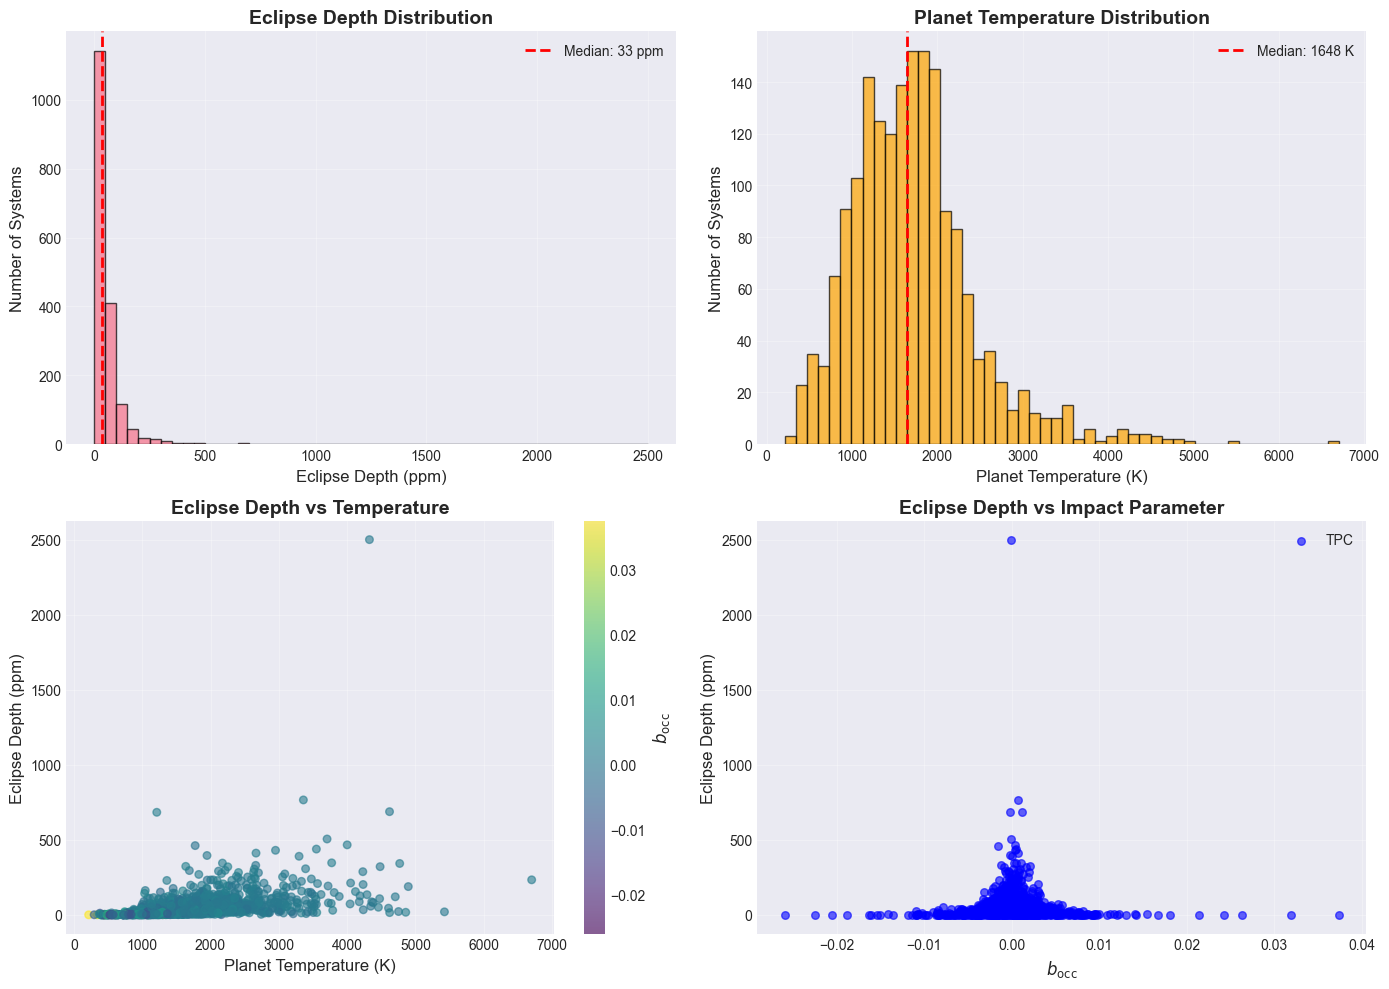

Figure saved to: ../results/eclipse_depth_distributions.png


In [10]:
if len(eclipse_results) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Extract data and filter outliers (remove depths > 10000 ppm)
    filtered_results = [r for r in eclipse_results if r['depth_ppm_median'] < 10000]
    depths_ppm = [r['depth_ppm_median'] for r in filtered_results]
    T_ps = [r['T_p_median'] for r in filtered_results]
    b_occs = [r['b_occ_median'] for r in filtered_results]
    datasets = [r['dataset'] for r in filtered_results]
    
    n_filtered = len(eclipse_results) - len(filtered_results)
    if n_filtered > 0:
        print(f"Note: Filtered {n_filtered} outlier(s) with eclipse depth > 10000 ppm from plots")
    
    # 1. Eclipse depth histogram
    ax = axes[0, 0]
    ax.hist(depths_ppm, bins=50, alpha=0.7, edgecolor='black')
    ax.set_xlabel('Eclipse Depth (ppm)', fontsize=12)
    ax.set_ylabel('Number of Systems', fontsize=12)
    ax.set_title('Eclipse Depth Distribution', fontsize=14, fontweight='bold')
    ax.axvline(np.median(depths_ppm), color='red', linestyle='--', linewidth=2, label=f'Median: {np.median(depths_ppm):.0f} ppm')
    ax.legend()
    ax.grid(alpha=0.3)
    
    # 2. Planet temperature histogram
    ax = axes[0, 1]
    ax.hist(T_ps, bins=50, alpha=0.7, edgecolor='black', color='orange')
    ax.set_xlabel('Planet Temperature (K)', fontsize=12)
    ax.set_ylabel('Number of Systems', fontsize=12)
    ax.set_title('Planet Temperature Distribution', fontsize=14, fontweight='bold')
    ax.axvline(np.median(T_ps), color='red', linestyle='--', linewidth=2, label=f'Median: {np.median(T_ps):.0f} K')
    ax.legend()
    ax.grid(alpha=0.3)
    
    # 3. Eclipse depth vs T_p
    ax = axes[1, 0]
    scatter = ax.scatter(T_ps, depths_ppm, alpha=0.6, s=30, c=b_occs, cmap='viridis')
    ax.set_xlabel('Planet Temperature (K)', fontsize=12)
    ax.set_ylabel('Eclipse Depth (ppm)', fontsize=12)
    ax.set_title('Eclipse Depth vs Temperature', fontsize=14, fontweight='bold')
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label(r'$b_{\rm occ}$', fontsize=12)
    ax.grid(alpha=0.3)
    
    # 4. Eclipse depth vs b_occ
    ax = axes[1, 1]
    ax.scatter(
        b_occs,
        depths_ppm,
        alpha=0.6,
        s=30,
        label='TPC',
        color='blue'
    )
    ax.set_xlabel(r'$b_{\rm occ}$', fontsize=12)
    ax.set_ylabel('Eclipse Depth (ppm)', fontsize=12)
    ax.set_title('Eclipse Depth vs Impact Parameter', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../results/eclipse_depth_distributions.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("Figure saved to: ../results/eclipse_depth_distributions.png")

## 11. Example: Detailed Analysis of Top Targets

Plot detailed distributions for the systems with the deepest eclipses.

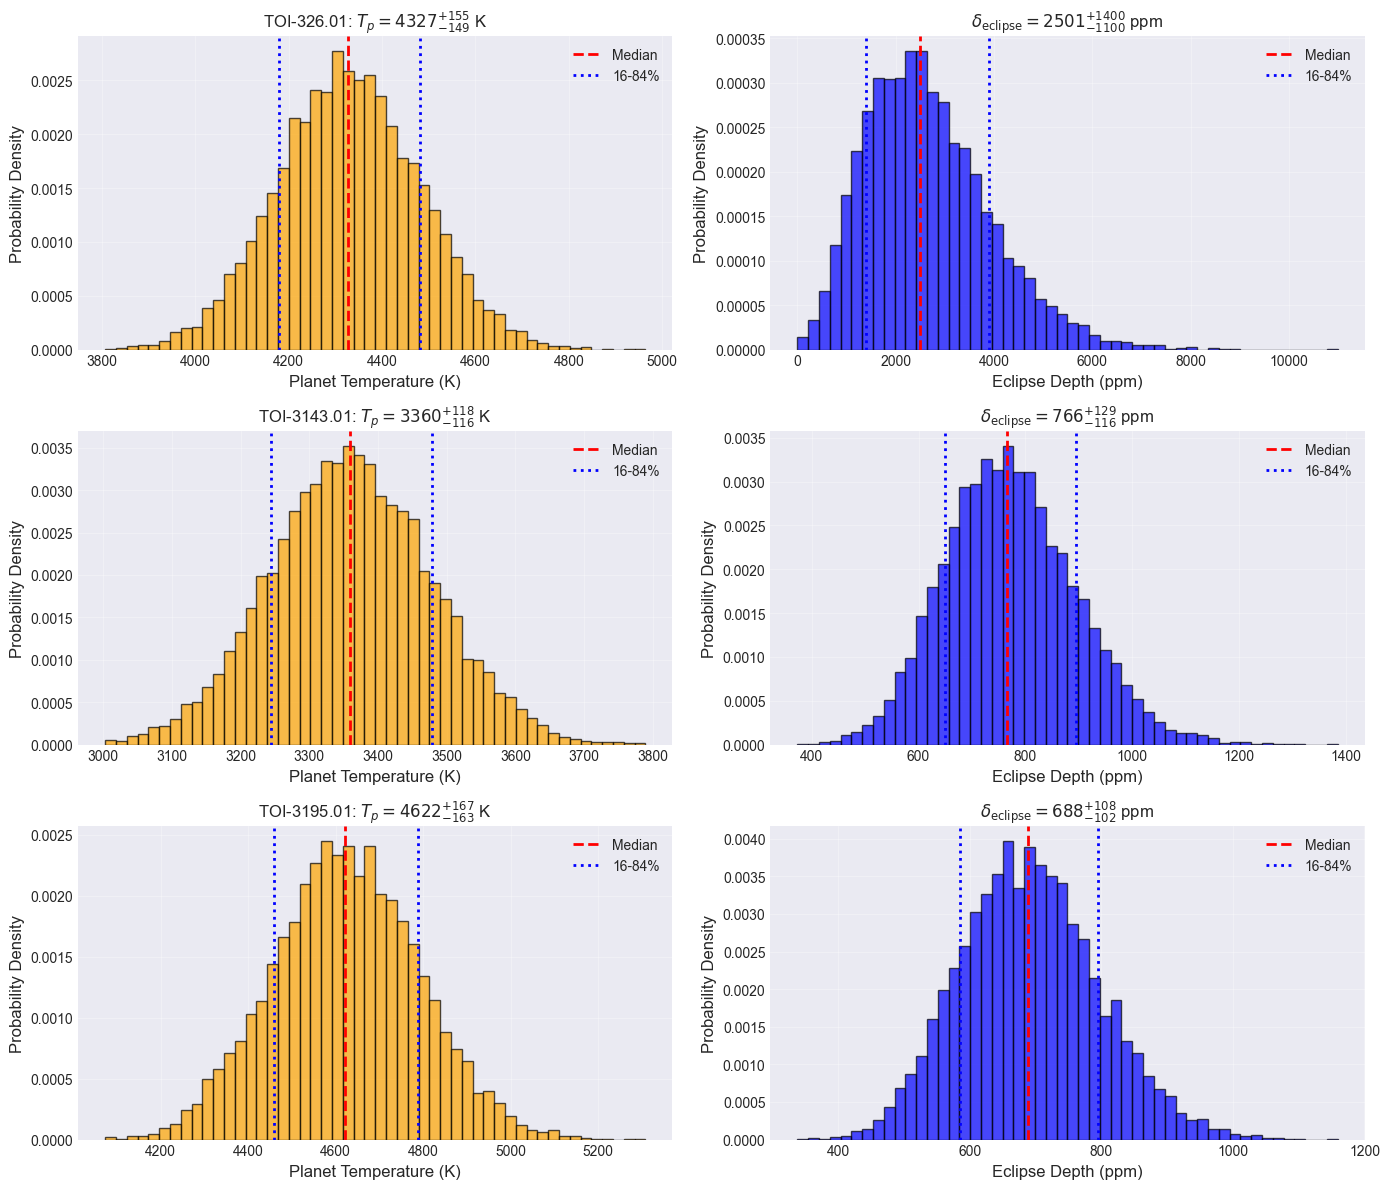

Figure saved to: ../results/top_targets_eclipse_depth.png


In [11]:
if len(eclipse_results) > 0:
    # Filter out results with NaN values and extreme outliers before sorting
    valid_results = [
        r for r in eclipse_results 
        if np.isfinite(r['depth_ppm_median']) and r['depth_ppm_median'] < 10000
    ]
    
    if len(valid_results) == 0:
        print("No valid results to plot.")
    else:
        # Sort by eclipse depth
        sorted_results = sorted(valid_results, key=lambda x: x['depth_ppm_median'], reverse=True)
        
        # Plot top 3
        n_plot = min(3, len(sorted_results))
        
        fig, axes = plt.subplots(n_plot, 2, figsize=(14, 4*n_plot))
        if n_plot == 1:
            axes = axes.reshape(1, -1)
        
        for i in range(n_plot):
            result = sorted_results[i]
            
            # Temperature distribution
            ax = axes[i, 0]
            ax.hist(result['T_p_samples'], bins=50, density=True, alpha=0.7, color='orange', edgecolor='black')
            ax.axvline(result['T_p_median'], color='red', linestyle='--', linewidth=2, label='Median')
            ax.axvline(result['T_p_median'] - result['T_p_err_lower'], color='blue', linestyle=':', linewidth=2)
            ax.axvline(result['T_p_median'] + result['T_p_err_upper'], color='blue', linestyle=':', linewidth=2, label='16-84%')
            ax.set_xlabel('Planet Temperature (K)', fontsize=12)
            ax.set_ylabel('Probability Density', fontsize=12)
            ax.set_title(f"{result['name']}: $T_p = {result['T_p_median']:.0f}^{{+{result['T_p_err_upper']:.0f}}}_{{-{result['T_p_err_lower']:.0f}}}$ K", fontsize=12)
            ax.legend()
            ax.grid(alpha=0.3)
            
            # Eclipse depth distribution
            ax = axes[i, 1]
            ax.hist(result['depth_ppm_samples'], bins=50, density=True, alpha=0.7, color='blue', edgecolor='black')
            ax.axvline(result['depth_ppm_median'], color='red', linestyle='--', linewidth=2, label='Median')
            ax.axvline(result['depth_ppm_median'] - result['depth_ppm_err_lower'], color='blue', linestyle=':', linewidth=2)
            ax.axvline(result['depth_ppm_median'] + result['depth_ppm_err_upper'], color='blue', linestyle=':', linewidth=2, label='16-84%')
            ax.set_xlabel('Eclipse Depth (ppm)', fontsize=12)
            ax.set_ylabel('Probability Density', fontsize=12)
            ax.set_title(f"$\\delta_{{\\rm eclipse}} = {result['depth_ppm_median']:.0f}^{{+{result['depth_ppm_err_upper']:.0f}}}_{{-{result['depth_ppm_err_lower']:.0f}}}$ ppm", fontsize=12)
            ax.legend()
            ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../results/top_targets_eclipse_depth.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("Figure saved to: ../results/top_targets_eclipse_depth.png")

## 12. Sensitivity Analysis: Albedo and Heat Redistribution

Explore how assumptions about albedo (A_B) and heat redistribution (f) affect eclipse depths.

Sensitivity analysis for: TOI-1007.01



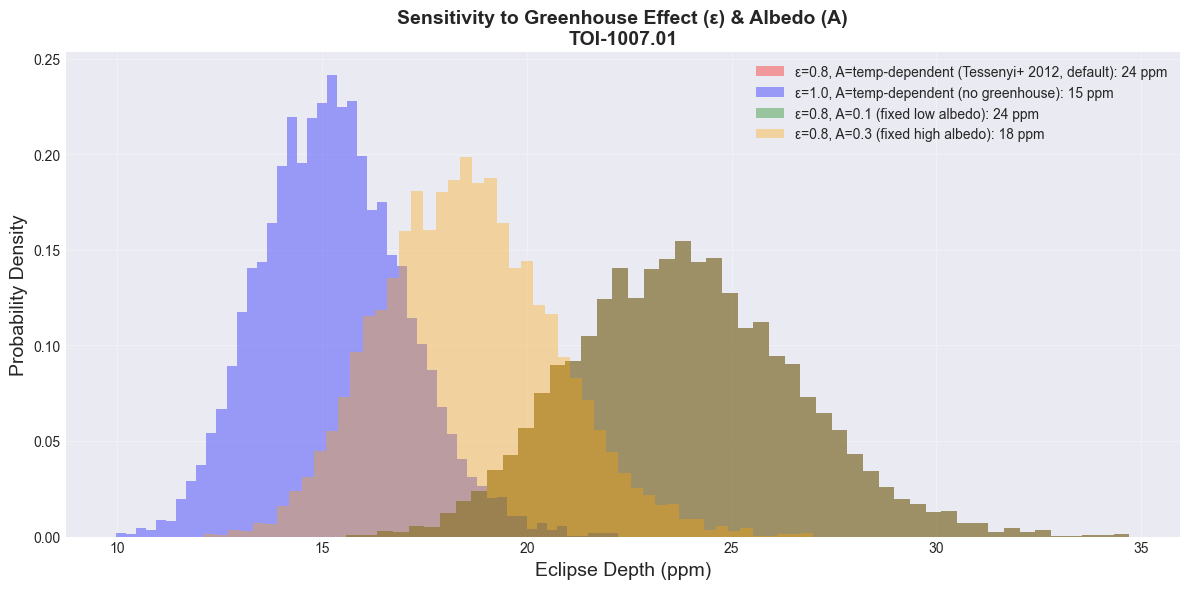

Figure saved to: ../results/sensitivity_analysis.png


In [12]:
if len(systems_for_analysis) > 0:
    # Pick a representative system
    test_system = systems_for_analysis[0]
    print(f"Sensitivity analysis for: {test_system['name']}\n")
    
    # Test different epsilon and albedo scenarios
    scenarios = [
        {'epsilon': 0.8, 'A': None, 'label': 'ε=0.8, A=temp-dependent (Tessenyi+ 2012, default)'},
        {'epsilon': 1.0, 'A': None, 'label': 'ε=1.0, A=temp-dependent (no greenhouse)'},
        {'epsilon': 0.8, 'A': 0.1, 'label': 'ε=0.8, A=0.1 (fixed low albedo)'},
        {'epsilon': 0.8, 'A': 0.3, 'label': 'ε=0.8, A=0.3 (fixed high albedo)'},
    ]
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    colors = ['red', 'blue', 'green', 'orange']
    
    for scenario, color in zip(scenarios, colors):
        # Create temporary modified version of planet_temperature for fixed albedo
        T_p_samples = []
        np.random.seed(42)
        T_star_samples = np.random.normal(test_system['T_star'], test_system['T_star_err'], 10000)
        R_star_samples = np.random.normal(test_system['R_star'], test_system['R_star_err'], 10000)
        R_p_samples = np.random.normal(test_system['R_p'], test_system['R_p_err'], 10000)
        a_samples = np.random.normal(test_system['a'], test_system['a_err'], 10000)
        
        T_star_samples = np.clip(T_star_samples, 2000, 50000)
        R_star_samples = np.clip(R_star_samples, 0.08, 50)
        R_p_samples = np.clip(R_p_samples, 0.01, 30)
        a_samples = np.clip(a_samples, 0.001, 100)
        
        for i in range(10000):
            T_p = planet_temperature(T_star_samples[i], R_star_samples[i], a_samples[i], 
                                    epsilon=scenario['epsilon'], A=scenario['A'])
            T_p_samples.append(T_p)
        
        T_p_samples = np.array(T_p_samples)
        depth_samples = eclipse_depth(R_p_samples, R_star_samples, T_p_samples, T_star_samples)
        depth_ppm_samples = depth_samples * 1e6
        
        ax.hist(
            depth_ppm_samples,
            bins=50,
            density=True,
            alpha=0.35,
            color=color,
            label=f"{scenario['label']}: {np.median(depth_ppm_samples):.0f} ppm"
        )
    
    ax.set_xlabel('Eclipse Depth (ppm)', fontsize=14)
    ax.set_ylabel('Probability Density', fontsize=14)
    ax.set_title(f"Sensitivity to Greenhouse Effect (ε) & Albedo (A)\n{test_system['name']}", fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../results/sensitivity_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("Figure saved to: ../results/sensitivity_analysis.png")

## 13. Filter Targets by Eclipse Depth Threshold

Identify systems that meet specific eclipse depth criteria for follow-up observations.

In [13]:
if len(eclipse_results) > 0:
    print("="*70)
    print("ECLIPSE DEPTH CLASSIFICATION")
    print("="*70)
    
    # Define detection thresholds (ppm)
    detection_thresholds = [30, 50, 100, 200, 300, 500]
    
    print("\nSystems BELOW threshold (easier to detect):")
    print("-" * 70)
    for threshold in detection_thresholds:
        count_below = sum(1 for r in eclipse_results if r['depth_ppm_median'] < threshold)
        pct_below = 100 * count_below / len(eclipse_results)
        print(f"  < {threshold:3d} ppm: {count_below:4d} systems ({pct_below:5.1f}%)")
    
    print("\nSystems ABOVE threshold (deeper eclipses):")
    print("-" * 70)
    for threshold in detection_thresholds:
        count_above = sum(1 for r in eclipse_results if r['depth_ppm_median'] >= threshold)
        pct_above = 100 * count_above / len(eclipse_results)
        print(f"  ≥ {threshold:3d} ppm: {count_above:4d} systems ({pct_above:5.1f}%)")
    
    # Traditional classification
    print("\n" + "="*70)
    print("TRADITIONAL CLASSIFICATION")
    print("="*70)
    
    categories = [
        ('Very Deep (>500 ppm)', lambda d: d > 500),
        ('Deep (300-500 ppm)', lambda d: 300 <= d <= 500),
        ('Moderate (100-300 ppm)', lambda d: 100 <= d < 300),
        ('Shallow (<100 ppm)', lambda d: d < 100)
    ]
    
    for category, condition in categories:
        count = sum(1 for r in eclipse_results if condition(r['depth_ppm_median']))
        pct = 100 * count / len(eclipse_results)
        print(f"{category}: {count:4d} ({pct:5.1f}%)")
    
    # Create filtered DataFrame for very deep eclipses
    print("\n" + "="*70)
    print("VERY DEEP ECLIPSE SYSTEMS (>500 ppm)")
    print("="*70)
    
    deep_systems = [
        r for r in eclipse_results
        if r['depth_ppm_median'] > 500
    ]
    
    if len(deep_systems) > 0:
        deep_data = []
        for r in deep_systems:
            deep_data.append({
                'Planet': r['name'],
                'Dataset': r['dataset'],
                'T_p (K)': f"{r['T_p_median']:.0f}",
                'Eclipse Depth (ppm)': f"{r['depth_ppm_median']:.0f}",
                'Depth Error': f"+{r['depth_ppm_err_upper']:.0f}/-{r['depth_ppm_err_lower']:.0f}",
                'b_occ': f"{r['b_occ_median']:.3f}"
            })
        
        deep_df = pd.DataFrame(deep_data)
        deep_df = deep_df.sort_values('Eclipse Depth (ppm)', ascending=False)
        display(deep_df)
        
        # Save
        deep_df.to_csv('../results/very_deep_eclipse_targets.csv', index=False)
        print(f"\nSaved to: ../results/very_deep_eclipse_targets.csv")
    else:
        print("No systems found with eclipse depth >500 ppm.")

ECLIPSE DEPTH CLASSIFICATION

Systems BELOW threshold (easier to detect):
----------------------------------------------------------------------
  <  30 ppm:  822 systems ( 40.2%)
  <  50 ppm: 1139 systems ( 55.7%)
  < 100 ppm: 1552 systems ( 75.9%)
  < 200 ppm: 1710 systems ( 83.6%)
  < 300 ppm: 1745 systems ( 85.3%)
  < 500 ppm: 1761 systems ( 86.1%)

Systems ABOVE threshold (deeper eclipses):
----------------------------------------------------------------------
  ≥  30 ppm:  945 systems ( 46.2%)
  ≥  50 ppm:  628 systems ( 30.7%)
  ≥ 100 ppm:  215 systems ( 10.5%)
  ≥ 200 ppm:   57 systems (  2.8%)
  ≥ 300 ppm:   22 systems (  1.1%)
  ≥ 500 ppm:    6 systems (  0.3%)

TRADITIONAL CLASSIFICATION
Very Deep (>500 ppm):    6 (  0.3%)
Deep (300-500 ppm):   16 (  0.8%)
Moderate (100-300 ppm):  193 (  9.4%)
Shallow (<100 ppm): 1552 ( 75.9%)

VERY DEEP ECLIPSE SYSTEMS (>500 ppm)


,Planet,Dataset,T_p (K),Eclipse Depth (ppm),Depth Error,b_occ
0,TOI-3143.01,TPC,3360,766,+129/-116,0.001
1,TOI-3195.01,TPC,4622,688,+108/-102,-0.000
3,TOI-472.01,TPC,1213,684,+108/-97,0.001
5,TOI-7388.01,TPC,3162,65701,+6712/-6092,0.000
4,TOI-5883.01,TPC,3707,506,+274/-214,-0.000
2,TOI-326.01,TPC,4327,2501,+1400/-1100,-0.000



Saved to: ../results/very_deep_eclipse_targets.csv


## Summary

This notebook successfully:

1. ✓ Loaded MCMC results from b_occ analysis
2. ✓ Extracted stellar parameters from raw data
3. ✓ Propagated uncertainties through planet temperature calculation
4. ✓ Calculated eclipse depth distributions for all systems
5. ✓ Identified top targets by eclipse depth
6. ✓ Performed sensitivity analysis on albedo and heat redistribution assumptions
7. ✓ Created comprehensive visualizations and summary tables

**Key Results:**
- Total systems analyzed: *Check Cell 8 output*
- Systems with >500 ppm eclipses: *Check Cell 13 output*
- Median eclipse depth: *Check Cell 9 output*
- Median planet temperature: *Check Cell 9 output*

**Output Files:**
- `../results/eclipse_depth_analysis.csv` - Full results table
- `../results/very_deep_eclipse_targets.csv` - Priority targets
- `../results/eclipse_depth_distributions.png` - Overview plots
- `../results/top_targets_eclipse_depth.png` - Detailed target plots
- `../results/sensitivity_analysis.png` - Albedo/redistribution sensitivity